<strong><b><font size="5">CNN Image Classification and Model Deployment using Flask in Python</font></b></strong>

In [3]:
# Set as 1 to train models, 0 to skip model training and load pre-trained models (Training takes time if using CPU)
train_models_flag = 0

In [25]:
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2025)

# TensorFlow/Keras imports (Updated for TF 2.x)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input # Updated layers
from tensorflow.keras.utils import to_categorical # Replaces np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import tensorflow as tf
from tensorflow.python.client import device_lib

import pickle
import pandas as pd
from skimage import io
# from scipy import misc  <-- REMOVED (Deprecated)
import skimage.transform as st # Use this for resizing instead
import cv2 # Optional: Good alternative for image processing

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
from flask import Flask, request, render_template

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Download and load Cifar-10 dataset

In [12]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 737s 4us/step


## Exploring the dataset

In [13]:
#NUmber of Target Classes
num_classes

10

In [14]:
#Dimensions of Train dataset
train_features.shape

(50000, 32, 32, 3)

In [ ]:
#Dimensions of Test dataset
test_features.shape

(10000, 32, 32, 3)

In [15]:
#Visualizing images for each class in the dataset

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

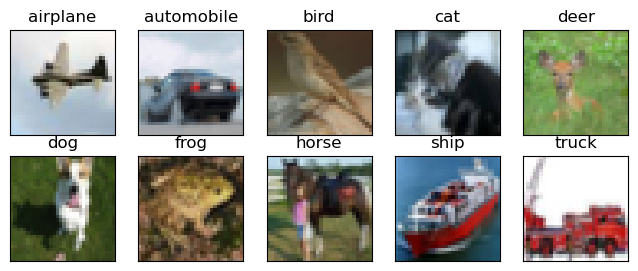

In [16]:
fig = plt.figure(figsize=(8,3))

# --- XỬ LÝ NHÃN (LABELS) AN TOÀN ---
# Kiểm tra xem labels đang ở dạng One-Hot (50000, 10) hay dạng số nguyên (50000, 1)
if train_labels.ndim == 2 and train_labels.shape[1] == num_classes:
    # Nếu là One-Hot (vd: [0, 1, 0...]), chuyển về số nguyên bằng argmax
    labels_integers = np.argmax(train_labels, axis=1)
else:
    # Nếu đã là số nguyên hoặc dạng (N, 1), chỉ cần làm phẳng thành (N,)
    labels_integers = train_labels.flatten()

# --- VẼ HÌNH ---
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])

    # Lấy index của các ảnh thuộc lớp i
    idx = np.where(labels_integers == i)[0]

    # Kiểm tra an toàn: Nếu không tìm thấy ảnh nào thuộc lớp này thì bỏ qua
    if len(idx) == 0:
        continue

    # Lấy dữ liệu ảnh
    features_idx = train_features[idx,::]

    # Chọn ngẫu nhiên một ảnh
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]

    # Xử lý chiều ảnh (Transpose) nếu cần
    # Nếu ảnh đang là (3, 32, 32) -> Chuyển thành (32, 32, 3) để hiển thị
    if im.shape[0] == 3 and im.shape[2] != 3:
        im = np.transpose(im, (1, 2, 0))

    ax.set_title(class_names[i])
    plt.imshow(im)

plt.show()

## Preprocessing

### Normalize
- Convert image features to a 0-1 scale, from a 0-255 scale, by dividing with the maximum (255)
- Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

In [17]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

### One-hot encoding - Convert class labels to binary class labels
- Converting multiclass target column into multiple binary target columns for using in a Machine Learning Model
- The classifier will be a multi-class classifier

In [18]:
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

__Support Function to plot model accuracy and loss:__

In [20]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

__Support function to compute test accuracy:__

In [21]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class)
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Compiling the network
 - Compile the network that we have just built by calling compile function
 - Parameters:
  - optimizer: Algorithm used by Keras to minimize the prediction scoring metric
  - loss: The objective function that will be minimized by the model
  - metrics: List of metrics to be evaluated by the model during training and testing

In [26]:
# Define the model

#Initialize the model
model = Sequential()

model.add(Input(shape=(32, 32, 3)))

# Step 1 - Convolution
model.add(Conv2D(48, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
train_models_flag = 0

if train_models_flag == 1:
    print("Bắt đầu huấn luyện mô hình...")
    start = time.time()

    # Huấn luyện
    model_info = model.fit(train_features, train_labels,
                           batch_size=128, epochs=10,
                           validation_data = (test_features, test_labels),
                           verbose=1)
    end = time.time()
    print(f"Huấn luyện xong trong {end - start} giây.")

    # TẠO THƯ MỤC NẾU CHƯA CÓ
    if not os.path.exists("saved_models"):
        os.makedirs("saved_models")

    # LƯU FILE .KERAS
    model.save("saved_models/tuned_model_fin.keras")
    print("Đã lưu model vào saved_models/tuned_model_fin.keras")

else:
    # Load Model
    model_info = 'saved_models/tuned_model_fin.keras'

    if not os.path.exists(model_info):
        print(f"LỖI: Không tìm thấy file {model_info}!")
        print("Vui lòng đặt train_models_flag = 1 để huấn luyện và tạo file trước.")
    else:
        print("Đang tải model...")
        model = load_model(model_info)
        print("Tải model thành công.")

Đang tải model...
Tải model thành công.


## Analyzing model performance

<br> Check model performance on both train and test data
- Plot Accuracy and loss for training and testing datasets at each epoch of model training

<b>Methods to improve model performance:</b>
- Hyper-parameters tuning
- Try other popular such as Lenet-5
- Use Dropout Regularization on the fully connected (dense) layers
- Augment the data size by scrapping more images for both classes and remove noisy ones

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # Plot Accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # Plot Loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()
if train_models_flag == 1:
  # plot model history
  plot_model_history(model_info)

  # Tính độ chính xác trên tập test (Cách mới cho TF 2.x)
  # Dùng hàm evaluate của model thay vì hàm accuracy tự viết cũ
  loss, acc = model.evaluate(test_features, test_labels, verbose=0)
  print("Accuracy on test data is: {:.2f}%".format(acc * 100))

## Hyperparameter tuning deep learning models

### Parameters - optimizing neural networks:

- Type of architecture
- Number of Layers
- Number of Neurons in a layer
- Type of optimization / backpropagation technique
- Dropout rate
- Regularization parameters

### Optimized CNN Architectures
- Convolutional neural networks (CNN) have typically had a standard structure - Stacked convolutional layers (optionally followed by contrast normalization and maxpooling) are followed by one or more fully-connected layers. </b>
- Variants of this basic design are prevalent in the image classification literature and have yielded the best results to-date on MNIST, CIFAR and most notably on the ImageNet classification challenge.
- For larger datasets such as Imagenet, the recent trend has been to increase the number of layers and layer size,
while using dropout to address the problem of overfitting.
- Popular CNN Architectures:
 - https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5
 - https://www.jeremyjordan.me/convnet-architectures/

<div style="display:block">
    <div style="display: inline-block; text-align: center;">
        <b>VGG - 16 Architecture</b>
        <img src="https://cdn-images-1.medium.com/max/1600/1*0Tk4JclhGOCR_uLe6RKvUQ.png" alt="VGG-16" height="300" width="450">
    </div>
    <div style="display: inline-block; text-align: center;">
        <b>AlexNet Architecture</b>
        <img src="https://www.researchgate.net/profile/Santosh_Ravi_Kiran_Sarvadevabhatla/publication/289928157/figure/fig7/AS:318276145041408@1452894354477/An-illustration-of-the-weights-in-the-AlexNet-model-Note-that-after-every-layer-there.png" alt="AlexNet" height="300" width="450">
    </div>
</div>

### Regularization

- <b>Dropout:</b> Randomly drop units (along with their connections) from the neural network during training. The reduction in number of parameters in each step of training has effect of regularization, preventing overfitting.

- <b>Kernel_regularizer:</b> Apply penalties on layer parameters during optimization. These penalties are incorporated in the loss function that the network optimizes (L2 regularisation of the weights), reducing overfitting.

- <b>Batch Normalization:</b> Normalizes the activation of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. It addresses the problem of internal covariate shift. It also acts as a regularizer, in some cases eliminating the need for Dropout.

__Implementing a better CNN model architecture:__

In [37]:
# Initialize the model
model = Sequential()

model.add(Input(shape=(32, 32, 3)))

# Đổi (3, 32, 32) thành (32, 32, 3) để khớp với format chuẩn của TensorFlow
model.add(Conv2D(48, (3, 3), padding='same', activation='relu'))

# Stacked Convolution layer
model.add(Conv2D(48, (3, 3), activation='relu'))

# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout for regularization
model.add(Dropout(0.25))

# Stacked Convolution layer
model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(96, (3, 3), activation='relu'))

# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stacked Convolution layer
model.add(Conv2D(192, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(192, (3, 3), activation='relu'))

# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully-connected layer
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))

# Fully-connected layer
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))

# Output Fully-connected layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# In tóm tắt mô hình để kiểm tra output shape
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,172,410 (4.47 MB)

 Trainable params: 1,172,410 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
train_models_flag = 0
if train_models_flag == 1:
    # Train the model

    start = time.time()
    model_info = model.fit(train_features, train_labels,
                           batch_size=64, epochs=30,
                           validation_data = (test_features, test_labels),
                           verbose=1)
    end = time.time()
    model.save("saved_models/tuned_model_final.keras")

     # plot model history
    plot_model_history(model_info)
    #print ("Model took {} seconds to train".format(end - start))
else:
    # Load Model
    saved_model = 'saved_models/tuned_model_final.keras'

    if not os.path.exists(saved_model):
        print(f"LỖI: Không tìm thấy file {saved_model}!")
        print("Vui lòng đặt train_models_flag = 1 để huấn luyện và tạo file trước.")
    else:
        print("Đang tải model...")
        model = load_model(saved_model)
        print("Tải model thành công.")

#compute test accuracy
print ("Accuracy on test data post hyperparameter tuning is: {}%".format(accuracy(test_features, test_labels, model)))

Đang tải model...
Tải model thành công.
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Accuracy on test data post hyperparameter tuning is: 80.02%


## Data augmentation
- One of the major reasons for overfitting is that you don’t have enough data to train your network.
- Apart from regularization, another very effective way to counter Overfitting is __Data Augmentation__.
- It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image.
- This can be done in Keras using the __ImageDataGenerator__ instance.
- __Includes rotation of the image, shifting the image left/right/top/bottom by some amount, flip the image horizontally or vertically, shear or zoom the image etc.__
- Augmentation has a __regularizing effect__. Too much of this combined with other forms of regularization (weight L2, dropout, etc.) can cause the net to __underfit__.
- [Keras image preprocessing - ImageDataGenerator](https://keras.io/preprocessing/image/)

In [42]:
#Load Model
saved_model = 'saved_models/tuned_model_final.keras'
loaded_model = load_model(saved_model)

# Convert numpy arrays to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))

# Define your augmentation layers (New Keras approach)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1), # approx 10 degrees varies by usage, check docs
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])

In [43]:

BATCH_SIZE = 128
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    .repeat() # Lặp vô tận để tránh lỗi "ran out of data"
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

train_models_flag = 0
if train_models_flag == 1:
    start = time.time()

    model_info = loaded_model.fit(
        train_dataset,
        steps_per_epoch=train_features.shape[0] // BATCH_SIZE,
        epochs=30,
        validation_data=(test_features, test_labels),
        verbose=1
    )

    end = time.time()
    print("Model took {} seconds to train".format(end - start))

    # --- ĐOẠN CODE LƯU MODEL (Giữ nguyên như cũ) ---
    if not os.path.exists("saved_models"):
        os.makedirs("saved_models")

    # Bạn vẫn gọi .save() trên object model bình thường
    loaded_model.save("saved_models/tuned_model_final1.keras")

    print("Đã lưu model thành công!")
else:
    # Load Model
    saved_model = 'saved_models/tuned_model_final1.keras'

    if not os.path.exists(saved_model):
        print(f"LỖI: Không tìm thấy file {saved_model}!")
        print("Vui lòng đặt train_models_flag = 1 để huấn luyện và tạo file trước.")
    else:
        print("Đang tải model...")
        loaded_model = load_model(saved_model)
        print("Tải model thành công.")

Đang tải model...
Tải model thành công.


## Model Deployment using Flask



### Define class names predicted by the model (in the right order)

In [44]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

### Define function to predict the passed image using the passed model

In [46]:
def classify(image, model):
    #Class names for cifar 10
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    preds = model.predict(image)
    classification = np.argmax(preds)
    final = pd.DataFrame({'name' : np.array(class_names),'probability' :preds[0]})
    return final.sort_values(by = 'probability',ascending=False),class_names[classification]

### Define flask application


In [49]:
app = Flask(__name__)
saved_model = 'saved_models/tuned_model_final1.keras'
model = load_model(saved_model)
if os.path.exists(saved_model):
    model = load_model(saved_model)
    print("Model đã tải thành công!")
else:
    print(f"Lỗi: Không tìm thấy file model tại {saved_model}")
    model = None

@app.route('/')
def entry_page():
    return render_template('index.html')

@app.route('/predict_object/', methods=['GET', 'POST'])
def render_message():
    # Khởi tạo giá trị mặc định để tránh lỗi biến không tồn tại
    image_url = None
    message = ""
    final = pd.DataFrame()

    try:
        if request.method == 'POST':
            # Get image URL as input
            image_url = request.form['image_url']
            
            # Kiểm tra url rỗng
            if not image_url:
                raise ValueError("URL hình ảnh không được để trống")

            # Đọc ảnh từ URL
            # Lưu ý: io.imread của skimage có thể đọc trực tiếp từ URL
            image = io.imread(image_url)

            # Apply same preprocessing used while training CNN model
            # Resize về 32x32 (theo code cũ của bạn)
            image_small = st.resize(image, (32, 32))
            
            # Thêm chiều batch: (32, 32, 3) -> (1, 32, 32, 3)
            x = np.expand_dims(image_small, axis=0)

            # Kiểm tra model đã load chưa
            if model is None:
                raise Exception("Model chưa được load thành công trên Server.")

            # Call classify function (Hàm này bạn tự định nghĩa ở đâu đó)
            # Giả sử hàm classify trả về (bảng kết quả, tên lớp)
            final, pred_class = classify(x, model)
            
            print(f"Dự đoán: {pred_class}")

            # Store model prediction results
            message = "Model prediction: {}".format(pred_class)
            print('Python module executed successfully')

    except Exception as e:
        # In lỗi ra màn hình console để debug
        print(f"LỖI CHI TIẾT: {e}")
        
        # Store error to pass to the web page
        message = "Error encountered. Try another image. Error: {}".format(str(e))
        final = pd.DataFrame({'A': ['Error'], 'B': [0]})

    # Return the model results to the web page
    return render_template('index.html',
                           message=message,
                           data=final.round(decimals=2) if not final.empty else final,
                           image_url=image_url)

Model đã tải thành công!


__Running the Flask Application:__

In [50]:
#Debug is disabled for running in a jupyter notebook
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [10/Dec/2025 21:40:16] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


127.0.0.1 - - [10/Dec/2025 21:40:37] "POST /predict_object/ HTTP/1.1" 200 -


Dự đoán: airplane
Python module executed successfully


127.0.0.1 - - [10/Dec/2025 21:40:54] "POST /predict_object/ HTTP/1.1" 200 -


LỖI CHI TIẾT: No such file: 'c:\AI\CNN\CNN-Image-Classification-and-Flask-Deployment\data:image\jpeg;base64,\9j\4AAQSkZJRgABAQAAAQABAAD\2wCEAAkGBxAPDxUQEhAVFRUVDxAVFRUXGBcVEA8PFRUWFhUVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OFxAQGy0eHyUuLS8tLSstKy0wKy0vLS0tLS0tLS0tLS0rLS8rLS0rLS0tLSstKy0tLS0tKy0tLS0rK\AABEIALQBGAMBIgACEQEDEQH\xAAbAAACAwEBAQAAAAAAAAAAAAAAAQIDBAUGB\EAEoQAAEDAQMHBwgJAQYGAwAAAAEAAhEDBBIhBRMxUVJhkUFxgZKh0fAGFBUiQpOx0iMyQ1NigqLB4bIWM2NywtMHRIOz4vEkc6P\xAAZAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX\xAAwEQACAgEABgkEAwEBAAAAAAAAAQIRAwQSEyFBkQUUMVFSYXGBobHR4fAiMkLBFf\aAAwDAQACEQMRAD8A+wAnWpAlIKQCWcx3igO3IhOEtFoAdymCoSneUKWIVd4ovlSi2TSUL5SvlWiWiwlKVG8UryUQneCLwUJQrQJ3wi+FCEJuBO8E7wVaFaQssLgleCghSkLJohRlF4oB3U7qjeTvJvBIBEqN5KVATlKVGUpQE1EpSlKACoOUiq3LSRCLlU5Tcq3LSRlsqemk9C0Zs6YaEQFAOUry4HcYB1og60ryLyEHG9ON6heReKoJoUJKUoQsSwUMUICaFHFGKAnKJCrxTxSgTvIvKCSAsvIvKuUSqC2+i+qpTlShZMuSlQlO8lAkhRvIvICSJUJRKAnKUKMolAOEQlKaAUKJCmkVbFFLgq3K9wVbldYy4mdwQpuCE1hqmkFO8qwU5WTRYHIvKEpyhScolQRKAnKJUE

127.0.0.1 - - [10/Dec/2025 21:41:08] "POST /predict_object/ HTTP/1.1" 200 -


Dự đoán: airplane
Python module executed successfully
